In [7]:
import numpy as np
import pandas as pd

from eval_utils import *
from model_evaluation import *

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('train.csv')

df.columns = df.columns.str.strip().str.replace(" ", "_")

## Препроцессинг

Повторим бейзлайн решение, обучив начальные модели 

In [8]:
df["Policy_Start_Date"] = pd.to_datetime(df["Policy_Start_Date"])
df["Policy_Year"] = df["Policy_Start_Date"].dt.year
df["Policy_Month"] = df["Policy_Start_Date"].dt.month
df["Policy_Day"] = df["Policy_Start_Date"].dt.day

In [9]:
numerical_features = [
    'Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
    'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
    'Policy_Year', 'Policy_Month', 'Policy_Day'
]

binary_features = ['Gender', 'Smoking_Status']
ordinal_features = ['Exercise_Frequency']
nominal_features = [
    'Marital_Status', 'Education_Level', 'Occupation',
    'Location', 'Policy_Type', 'Customer_Feedback', 'Property_Type'
]

In [10]:
X = df.drop(['Premium_Amount'], axis=1, errors='ignore')
y = np.log1p(df['Premium_Amount'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Шаг 4: Универсальный препроцессинг
X_train_proc, X_test_proc, y_train, y_test = get_baseline_preprocessing(
    X_train, X_test, y_train, y_test,
    numerical_features, binary_features, ordinal_features, nominal_features
)
baseline_results = run_experiment(X_train_proc, X_test_proc, y_train, y_test, 
                                 "Бейзлайн")


ЭКСПЕРИМЕНТ: Бейзлайн
Train shape: (960000, 39), Test shape: (240000, 39)
{'model': 'DecisionTreeRegressor', 'mse': 849766.301189081, 'rmse': np.float64(921.8276960414463), 'mae': 622.8141455968585, 'r2': -0.13713728321217622, 'rmsle': np.float64(1.0507390599892081)}

DecisionTreeRegressor - Кросс-валидация (5 folds)...
CV MSE: 851373.2128 (+/- 4085.6411)
CV RMSE: 922.6962 (+/- 2.2116)
CV RMSLE: 1.0507 (+/- 0.0020)
{'model': 'RandomForestRegressor', 'mse': 862373.0876211964, 'rmse': np.float64(928.640451208753), 'mae': 626.5411957929497, 'r2': -0.154007388385083, 'rmsle': np.float64(1.0615979875516908)}

RandomForestRegressor - Кросс-валидация (5 folds)...
CV MSE: 864526.8871 (+/- 3629.6710)
CV RMSE: 929.7973 (+/- 1.9499)
CV RMSLE: 1.0609 (+/- 0.0018)
{'model': 'XGBoost', 'mse': 859747.3439568513, 'rmse': np.float64(927.2256165339973), 'mae': 625.43499733874, 'r2': -0.15049367995406282, 'rmsle': np.float64(1.0533180971674656)}

XGBoost - Кросс-валидация (5 folds)...
CV MSE: 861143.705

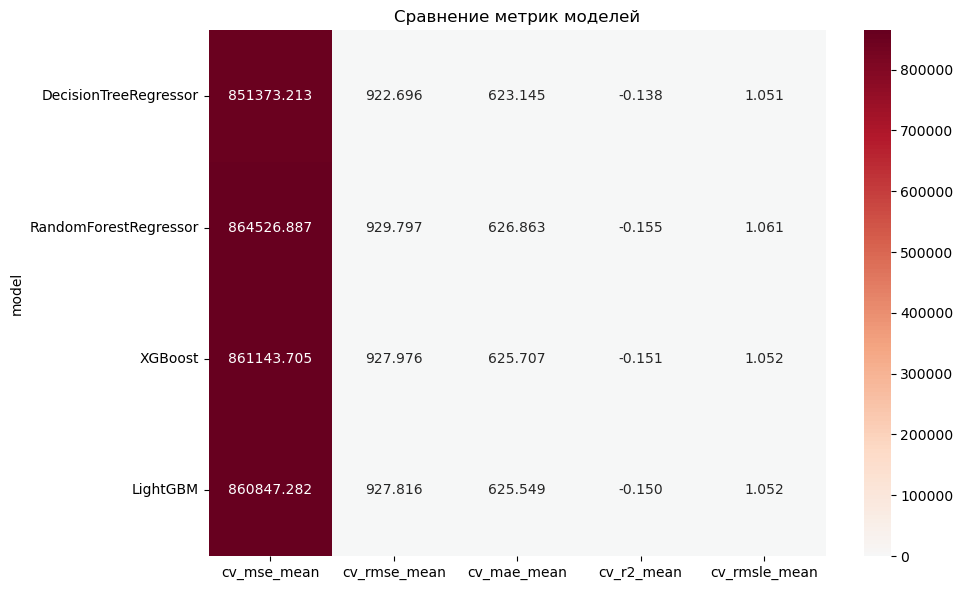

In [11]:
baseline_metrics = compare_models_metrics(baseline_results)

## Feature engineering

Будем использовать итеративный подход, поочередно применять удачные преобразования, сравнивая результат каждого нового преобразования с результатом предыдущего.

### Подход №1

При анализе числовых признаков, Annual_Income т.е. доход клиента оказался сильно ассиметричным. Попробуем перевести его в категориальный, произведя бинаризацию. Делать это будем отдельно для train и test, чтобы не допустить утечки информации. Границы разбиения вычисляются только на тренировочной выборке, а затем применяются к тестовой.

In [ ]:
def create_income_bins(X_train, X_test, feature='Annual_Income'):
    """
    Создает Income_Group
    Fit на train, transform на test
    """
    labels = ["Low Income", "Mid-Low", "Mid-High", "High Income"]
    
    _, bins = pd.qcut(X_train[feature], q=4, labels=labels, retbins=True, duplicates='drop')
    
    bins[0] = -np.inf
    bins[-1] = np.inf
    
    X_train["Income_Group"] = pd.cut(X_train[feature], bins=bins, labels=labels, include_lowest=True)
    X_test["Income_Group"] = pd.cut(X_test[feature], bins=bins, labels=labels, include_lowest=True)
    
    return X_train, X_test


In [ ]:
X_train, X_test = create_income_bins(X_train, X_test)

numerical_features = [
    'Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
    'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
    'Policy_Year', 'Policy_Month', 'Policy_Day'
]
binary_features = ['Gender', 'Smoking_Status']
ordinal_features = ['Exercise_Frequency', 'Income_Group']
nominal_features = [
    'Marital_Status', 'Education_Level', 'Occupation',
    'Location', 'Policy_Type', 'Customer_Feedback', 'Property_Type'
]

X_train_proc, X_test_proc, y_train, y_test = get_baseline_preprocessing(
    X_train, X_test, y_train, y_test,
    numerical_features, binary_features, ordinal_features, nominal_features
)

# Шаг 5: Обучени моделей
exp1_results = run_experiment(
    X_train_proc, X_test_proc, y_train, y_test,
    "Бинаризация группы дохода клиента"
)


ЭКСПЕРИМЕНТ: Бинаризация группы дохода клиента
Train shape: (960000, 40), Test shape: (240000, 40)
{'model': 'DecisionTreeRegressor', 'mse': 849901.237742428, 'rmse': np.float64(921.9008828189872), 'mae': 622.4967821584694, 'r2': -0.13731785213502512, 'rmsle': np.float64(1.05058627288655)}

DecisionTreeRegressor - Кросс-валидация (5 folds)...
CV MSE: 851807.0720 (+/- 3809.3940)
CV RMSE: 922.9316 (+/- 2.0621)
CV RMSLE: 1.0507 (+/- 0.0020)
{'model': 'RandomForestRegressor', 'mse': 860696.9804666399, 'rmse': np.float64(927.737560124974), 'mae': 625.5221051717112, 'r2': -0.15176446120211762, 'rmsle': np.float64(1.0595981412014321)}

RandomForestRegressor - Кросс-валидация (5 folds)...
CV MSE: 862705.7638 (+/- 3696.6809)
CV RMSE: 928.8174 (+/- 1.9878)
CV RMSLE: 1.0588 (+/- 0.0016)
{'model': 'XGBoost', 'mse': 857390.1507176163, 'rmse': np.float64(925.9536439356002), 'mae': 624.6715599522273, 'r2': -0.14733933938734567, 'rmsle': np.float64(1.0516488789393708)}

XGBoost - Кросс-валидация (5 f

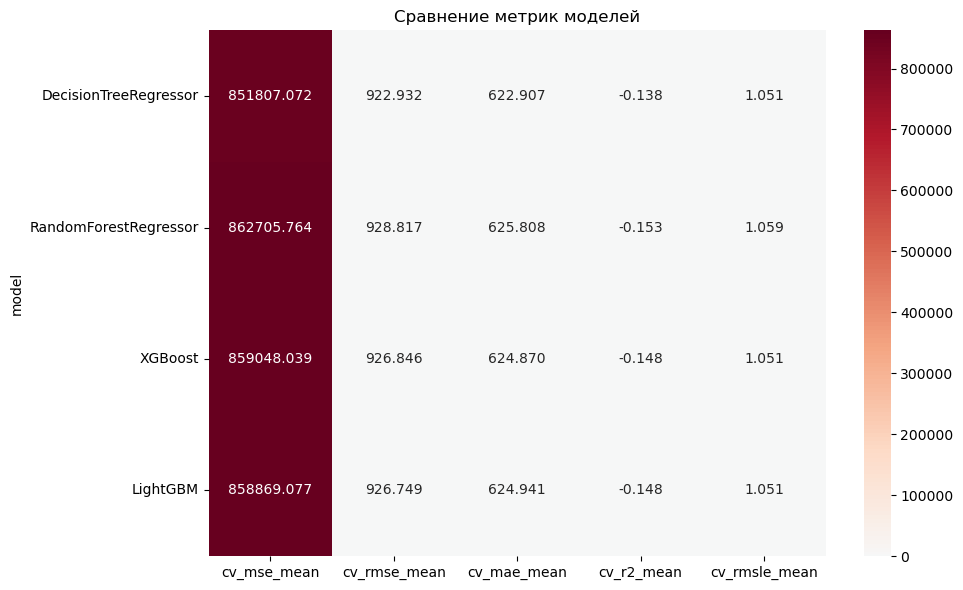

In [14]:
exp1_metrics = compare_models_metrics(exp1_results)

,cv_mse_mean,cv_rmse_mean,cv_mae_mean,cv_r2_mean,cv_rmsle_mean
model,,,,,
DecisionTreeRegressor,433.859235,0.235420,-0.237597,-0.000580,0.000011
RandomForestRegressor,-1821.123230,-0.979909,-1.054692,0.002433,-0.002061
XGBoost,-2095.665690,-1.129730,-0.836541,0.002800,-0.001776
LightGBM,-1978.205290,-1.066779,-0.608341,0.002643,-0.001295


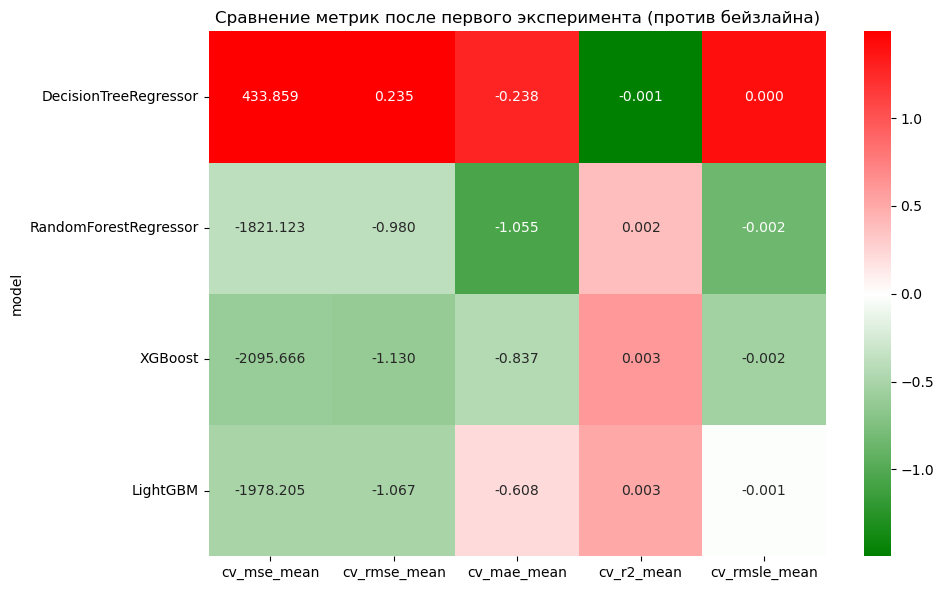

In [15]:
compare_after_add(exp1_metrics, baseline_metrics, 'Сравнение метрик после первого эксперимента (против бейзлайна)')

Снизились среднеквадратичные ошибки и MAE для всех моделей кроме случайного леса

### Подход №2

Сделаем аналогичное преобразования для признака Health_Score, также вычисляем границы на train и применяем на test:

In [ ]:
def create_health_bins(X_train, X_test, feature='Health_Score'):
    """
    Создает Health_Score БЕЗ утечки данных
    Fit на train, transform на test
    """
    labels = ["High Risk", "Medium Risk", "Low Risk"]
    
    _, bins = pd.qcut(X_train[feature], q=3, labels=labels, retbins=True, duplicates='drop')
    
    bins[0] = -np.inf
    bins[-1] = np.inf
    
    X_train["Health_Risk_Level"] = pd.cut(X_train[feature], bins=bins, labels=labels, include_lowest=True)
    X_test["Health_Risk_Level"] = pd.cut(X_test[feature], bins=bins, labels=labels, include_lowest=True)
    
    return X_train, X_test

In [ ]:
X_train, X_test = create_health_bins(X_train, X_test)

numerical_features = [
    'Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
    'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
    'Policy_Year', 'Policy_Month', 'Policy_Day'
]
binary_features = ['Gender', 'Smoking_Status']
ordinal_features = ['Exercise_Frequency', 'Income_Group', 'Health_Risk_Level']
nominal_features = [
    'Marital_Status', 'Education_Level', 'Occupation',
    'Location', 'Policy_Type', 'Customer_Feedback', 'Property_Type'
]

X_train_proc, X_test_proc, y_train, y_test = get_baseline_preprocessing(
    X_train, X_test, y_train, y_test,
    numerical_features, binary_features, ordinal_features, nominal_features
)

exp2_results = run_experiment(
    X_train_proc, X_test_proc, y_train, y_test,
    "Бинаризация рейтинга здоровья"
)


ЭКСПЕРИМЕНТ: Бинаризация рейтинга здоровья
Train shape: (960000, 41), Test shape: (240000, 41)
{'model': 'DecisionTreeRegressor', 'mse': 850880.7201682997, 'rmse': np.float64(922.4319596416311), 'mae': 622.5074072780494, 'r2': -0.13862857248619842, 'rmsle': np.float64(1.0504079271667857)}

DecisionTreeRegressor - Кросс-валидация (5 folds)...
CV MSE: 852602.4112 (+/- 4125.8230)
CV RMSE: 923.3620 (+/- 2.2322)
CV RMSLE: 1.0501 (+/- 0.0017)
{'model': 'RandomForestRegressor', 'mse': 859000.6347173929, 'rmse': np.float64(926.8228712744377), 'mae': 624.4972385601657, 'r2': -0.14949445120761928, 'rmsle': np.float64(1.0582645380449283)}

RandomForestRegressor - Кросс-валидация (5 folds)...
CV MSE: 860290.9617 (+/- 4021.9491)
CV RMSE: 927.5162 (+/- 2.1660)
CV RMSLE: 1.0571 (+/- 0.0021)
{'model': 'XGBoost', 'mse': 856367.5153143671, 'rmse': np.float64(925.4012725917158), 'mae': 623.8954634645462, 'r2': -0.14597087273652654, 'rmsle': np.float64(1.0502169859566084)}

XGBoost - Кросс-валидация (5 f

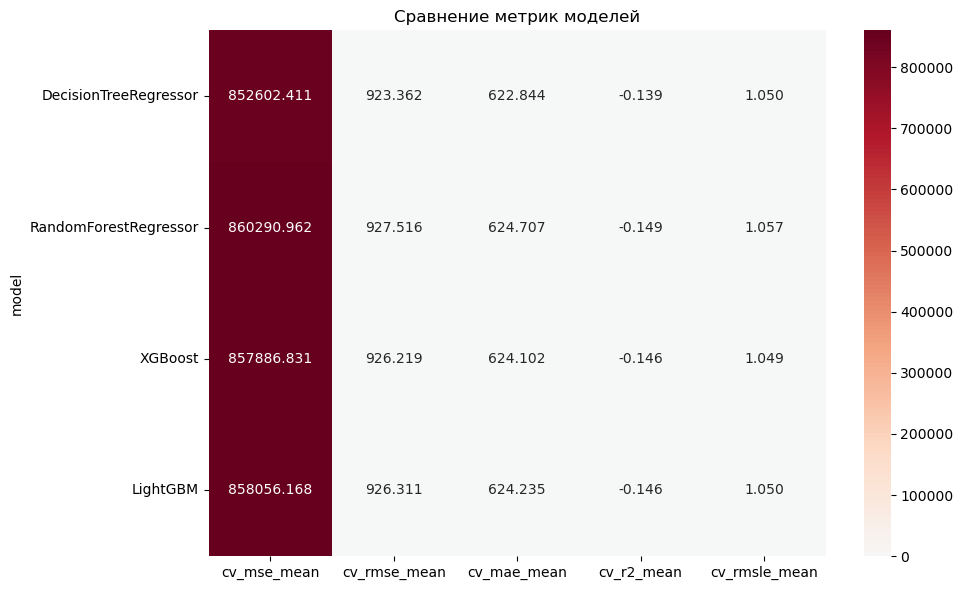

,cv_mse_mean,cv_rmse_mean,cv_mae_mean,cv_r2_mean,cv_rmsle_mean
model,,,,,
DecisionTreeRegressor,795.339162,0.430380,-0.062709,-0.001062,-0.000591
RandomForestRegressor,-2414.802115,-1.301244,-1.101160,0.003228,-0.001700
XGBoost,-1161.208450,-0.626719,-0.768788,0.001552,-0.001307
LightGBM,-812.908897,-0.438834,-0.705961,0.001086,-0.001182


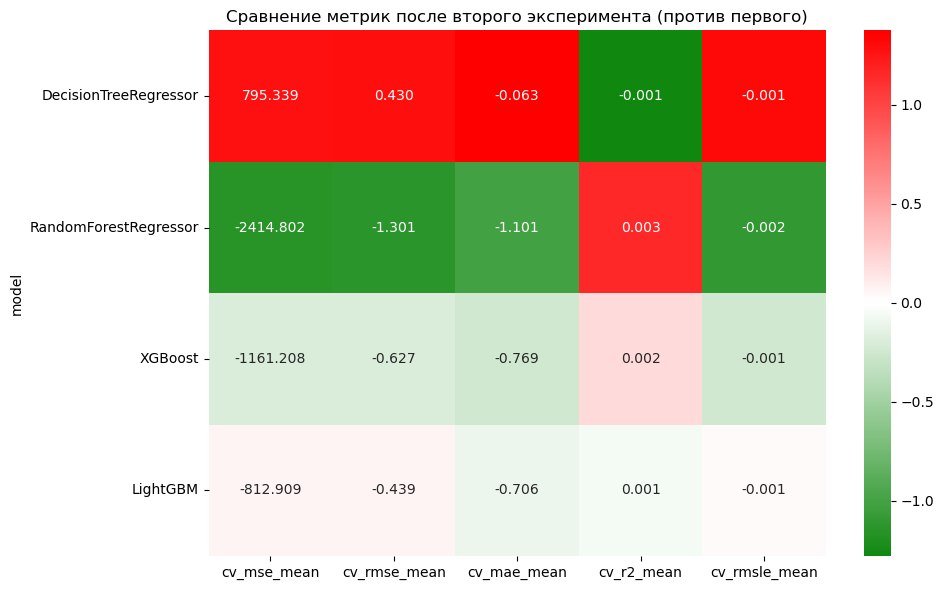

In [18]:
exp2_metrics = compare_models_metrics(exp2_results)
compare_after_add(exp2_metrics, exp1_metrics, 'Сравнение метрик после второго эксперимента (против первого)')

Видим аналогичные первому подходу улучшения метрик, идем даль

### Подход №3 

Для того чтобы модели могли лучше уловить нелинейные зависимости, ведем три новых признака взаимодействий - 

- между возрастом и рейтингом здоровья, 
- возрастом автомобиля клиента и кол-вом предыдущих обращений,
- рейтингом здоровья и кол-вом предыдущуих обращений.

In [19]:
def create_interaction_features(df):
    """
    Добавляет взаимодействия признаков
    """
    df["Age_Health"] = df["Age"] * df["Health_Score"] #возраст и рейтинг здоровья

    df["VehicleAge_Claims"] = df["Vehicle_Age"] * df["Previous_Claims"] #возраст автомобиля и кол-во обращений клиента

    df["Health_Claims"] = df["Health_Score"] * df["Previous_Claims"] #рейтинг здоровья и кол-во обращений клиента

    return df

In [ ]:
X_train = create_interaction_features(X_train)
X_test = create_interaction_features(X_test)

X_train, X_test = create_income_bins(X_train, X_test)

numerical_features = [
    'Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
    'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
    'Policy_Year', 'Policy_Month', 'Policy_Day',
    'Age_Health', 'VehicleAge_Claims'
]

binary_features = ['Gender', 'Smoking_Status']
ordinal_features = ['Exercise_Frequency', 'Income_Group','Health_Risk_Level']
nominal_features = [
    'Marital_Status', 'Education_Level', 'Occupation',
    'Location', 'Policy_Type', 'Customer_Feedback', 'Property_Type'
]

X_train_proc, X_test_proc, y_train, y_test = get_baseline_preprocessing(
    X_train, X_test, y_train, y_test,
    numerical_features, binary_features, ordinal_features, nominal_features
)

exp3_results = run_experiment(X_train_proc, X_test_proc, y_train, y_test,
                                "Добавляет взаимодействия признаков: возраст и рейтинг здоровья, возраст автомобиля и кол-во обращений клиента")




ЭКСПЕРИМЕНТ: Добавляет взаимодействия признаков: возраст и рейтинг здоровья, возраст автомобиля и кол-во обращений клиента
Train shape: (960000, 43), Test shape: (240000, 43)
{'model': 'DecisionTreeRegressor', 'mse': 850819.6371074036, 'rmse': np.float64(922.3988492552469), 'mae': 622.309987696569, 'r2': -0.13854683257038802, 'rmsle': np.float64(1.0502925088804762)}

DecisionTreeRegressor - Кросс-валидация (5 folds)...
CV MSE: 852425.8409 (+/- 4009.3364)
CV RMSE: 923.2666 (+/- 2.1693)
CV RMSLE: 1.0499 (+/- 0.0017)
{'model': 'RandomForestRegressor', 'mse': 859001.567161084, 'rmse': np.float64(926.8233743066065), 'mae': 624.500067540187, 'r2': -0.14949569898184145, 'rmsle': np.float64(1.0582654626783665)}

RandomForestRegressor - Кросс-валидация (5 folds)...
CV MSE: 860297.5332 (+/- 4017.5408)
CV RMSE: 927.5197 (+/- 2.1636)
CV RMSLE: 1.0571 (+/- 0.0021)
{'model': 'XGBoost', 'mse': 856433.8191713782, 'rmse': np.float64(925.4370962801189), 'mae': 623.890987530899, 'r2': -0.146059598998938

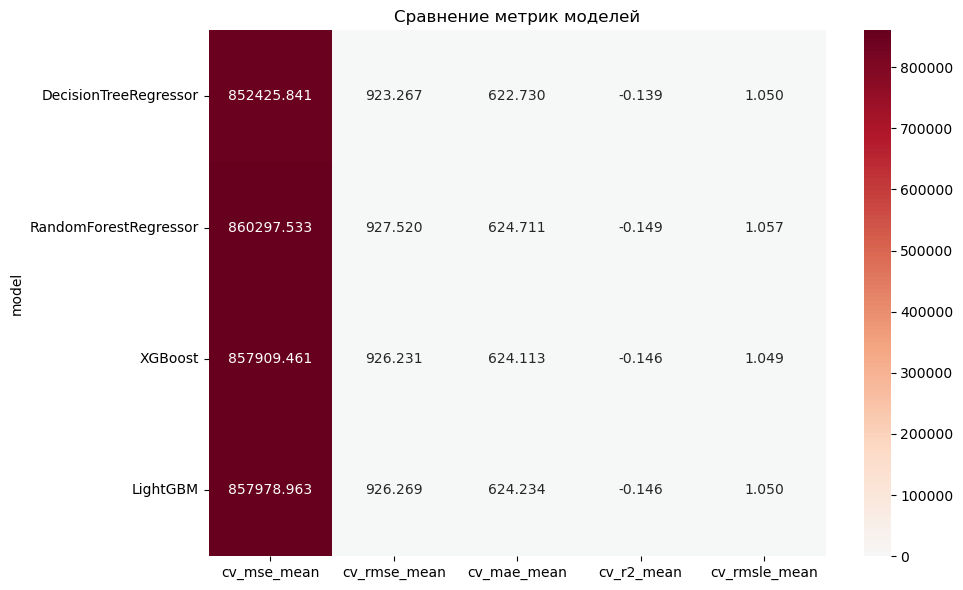

,cv_mse_mean,cv_rmse_mean,cv_mae_mean,cv_r2_mean,cv_rmsle_mean
model,,,,,
DecisionTreeRegressor,-176.570289,-0.095468,-0.113857,0.000235,-0.000151
RandomForestRegressor,6.571489,0.003548,0.003831,-0.000009,0.000005
XGBoost,22.630504,0.012221,0.011242,-0.000030,0.000002
LightGBM,-77.204850,-0.041697,-0.000289,0.000103,0.000016


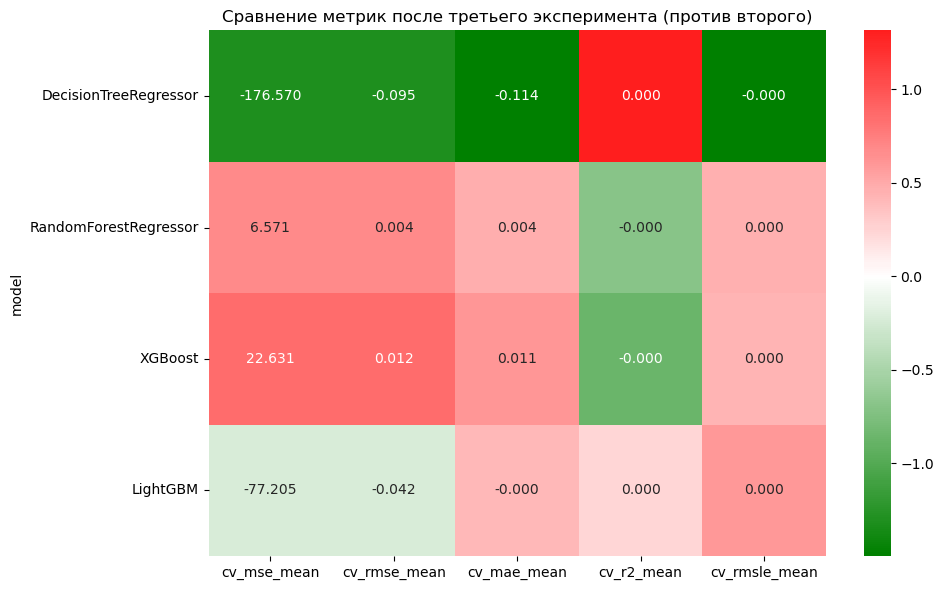

In [21]:
exp3_metrics = compare_models_metrics(exp3_results)
compare_after_add(exp3_metrics, exp2_metrics, 'Сравнение метрик после третьего эксперимента (против второго)')

Метрики особо сильно не улучшились, но при этом и не ухудшулись. Оставим их, возможно они смогут внести свой вклад при подборе гиперпараметров

## Подход 4

Ну и в последнем подходе, ко всем существующим признакам, добавим  признаки на основе даты начала полиса (Policy_Start_Date):

- Day_of_week — день недели (0–6)
- Week — номер недели в году
- Year_sin, Year_cos — циклическое представление года
- Month_sin, Month_cos — циклическое представление месяца
- Day_sin, Day_cos — циклическое представление дня месяца
- Group — агрегированный порядковый номер периода (грубо: неделя с 2020 года)
- days_elapsed — количество дней, прошедших с минимальной даты в выборке

In [22]:
def create_date_features(df):
    """
    Создает временные признаки на основе даты начала полиса (Policy_Start_Date).

    Добавляемые признаки:
    - Day_of_week — день недели (0–6)
    - Week — номер недели в году
    - Year_sin, Year_cos — циклическое представление года
    - Month_sin, Month_cos — циклическое представление месяца
    - Day_sin, Day_cos — циклическое представление дня месяца
    - Group — агрегированный порядковый номер периода (грубо: неделя с 2020 года)
    - days_elapsed — количество дней, прошедших с минимальной даты в выборке
    """
    df['Day_of_week'] = df['Policy_Start_Date'].dt.dayofweek
    df['Week'] = df['Policy_Start_Date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Policy_Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Policy_Year'])
    df['Month_sin'] = np.sin(2 * np.pi * df['Policy_Month'] / 12) 
    df['Month_cos'] = np.cos(2 * np.pi * df['Policy_Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Policy_Day'] / 31)  
    df['Day_cos'] = np.cos(2 * np.pi * df['Policy_Day'] / 31)
    df['Group']=(df['Policy_Year']-2020)*48+df['Policy_Month']*4+df['Policy_Day']//7

    df['days_elapsed'] = (df['Policy_Start_Date'] -  df['Policy_Start_Date'].min()).dt.days

    return df

In [ ]:

X_train = create_date_features(X_train)
X_test = create_date_features(X_test)

numerical_features = [
    'Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
    'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
    'Policy_Year', 'Policy_Month', 'Policy_Day',
    'Age_Health', 'VehicleAge_Claims', 'Health_Claims',

    'Day_of_week', 'Week', 'Group', 'days_elapsed',
    'Year_sin', 'Year_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos'
]

binary_features = ['Gender', 'Smoking_Status']


ordinal_features = ['Exercise_Frequency', 'Income_Group', 'Health_Risk_Level']

nominal_features = [
    'Marital_Status', 'Education_Level', 'Occupation',
    'Location', 'Policy_Type', 'Customer_Feedback', 'Property_Type'
]

X_train_proc, X_test_proc, y_train, y_test = get_baseline_preprocessing(
    X_train, X_test, y_train, y_test,
    numerical_features, binary_features, ordinal_features, nominal_features
)

exp4_results = run_experiment(X_train_proc, X_test_proc, y_train, y_test,
                                "Добавляет признаки на освове даты начала полиса")





ЭКСПЕРИМЕНТ: Добавляет признаки на освове даты начала полиса
Train shape: (960000, 54), Test shape: (240000, 54)
{'model': 'DecisionTreeRegressor', 'mse': 850585.4197253627, 'rmse': np.float64(922.2718795048252), 'mae': 622.3453368340037, 'r2': -0.13823340837702758, 'rmsle': np.float64(1.0502466830817405)}

DecisionTreeRegressor - Кросс-валидация (5 folds)...
CV MSE: 852342.4653 (+/- 3835.1698)
CV RMSE: 923.2216 (+/- 2.0754)
CV RMSLE: 1.0499 (+/- 0.0019)
{'model': 'RandomForestRegressor', 'mse': 859018.8879319386, 'rmse': np.float64(926.832718418992), 'mae': 624.5052513107189, 'r2': -0.14951887723012613, 'rmsle': np.float64(1.0582719380780727)}

RandomForestRegressor - Кросс-валидация (5 folds)...
CV MSE: 860285.3491 (+/- 4014.4442)
CV RMSE: 927.5132 (+/- 2.1620)
CV RMSLE: 1.0571 (+/- 0.0021)
{'model': 'XGBoost', 'mse': 856487.328978684, 'rmse': np.float64(925.4660063874221), 'mae': 623.9172164296468, 'r2': -0.1461312045648684, 'rmsle': np.float64(1.0502695572710516)}

XGBoost - Кросс

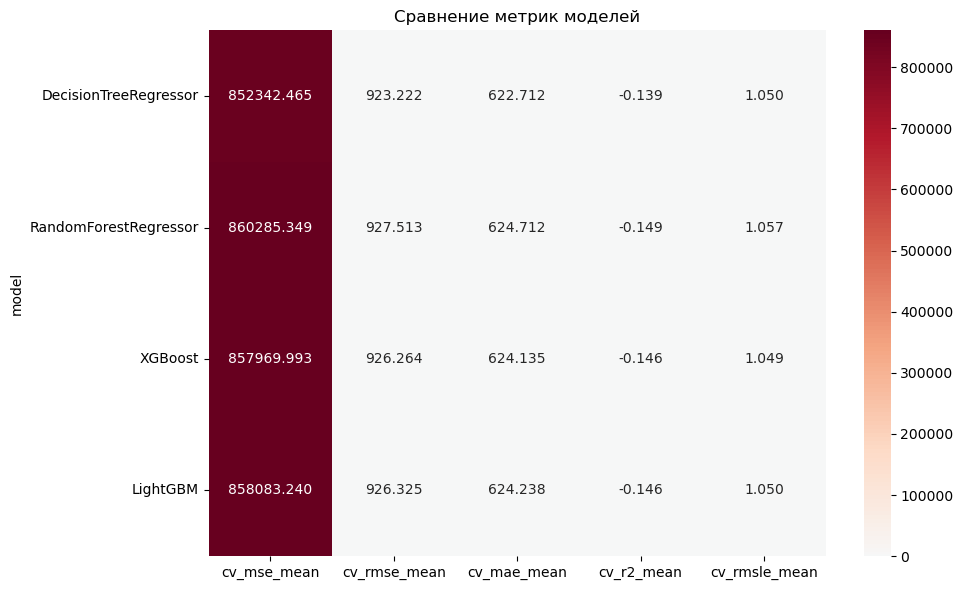

,cv_mse_mean,cv_rmse_mean,cv_mae_mean,cv_r2_mean,cv_rmsle_mean
model,,,,,
DecisionTreeRegressor,-83.375588,-0.044938,-0.018779,0.000111,0.000017
RandomForestRegressor,-12.184104,-0.006564,0.000978,0.000016,0.000003
XGBoost,60.531682,0.032693,0.022325,-0.000081,0.000019
LightGBM,104.277328,0.056389,0.003372,-0.000139,-0.000004


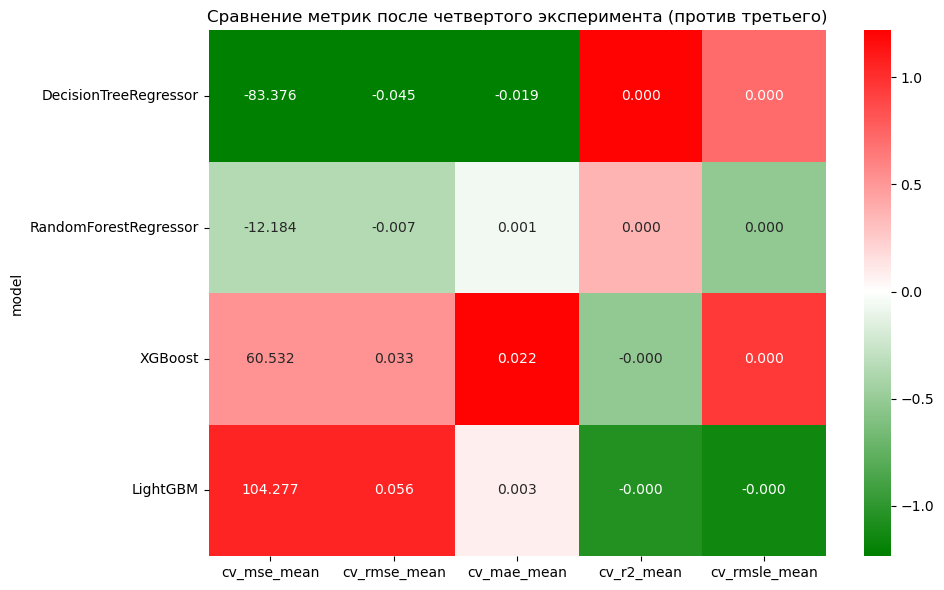

In [24]:
exp4_metrics = compare_models_metrics(exp4_results)
compare_after_add(exp4_metrics, exp3_metrics, 'Сравнение метрик после четвертого эксперимента (против третьего)')

Тут аналогично, каких то сильных изменений нет, как и в предыдущем случае - оставляем

Итого после всех преобразований, метрики по сравнению с бейзлайном увеличелись следующим образом:

,cv_mse_mean,cv_rmse_mean,cv_mae_mean,cv_r2_mean,cv_rmsle_mean
model,,,,,
DecisionTreeRegressor,969.252520,0.525395,-0.432943,-0.001295,-0.000714
RandomForestRegressor,-4241.537961,-2.284168,-2.151044,0.005669,-0.003752
XGBoost,-3173.711954,-1.711535,-1.571762,0.004240,-0.003061
LightGBM,-2764.041709,-1.490921,-1.311220,0.003693,-0.002465


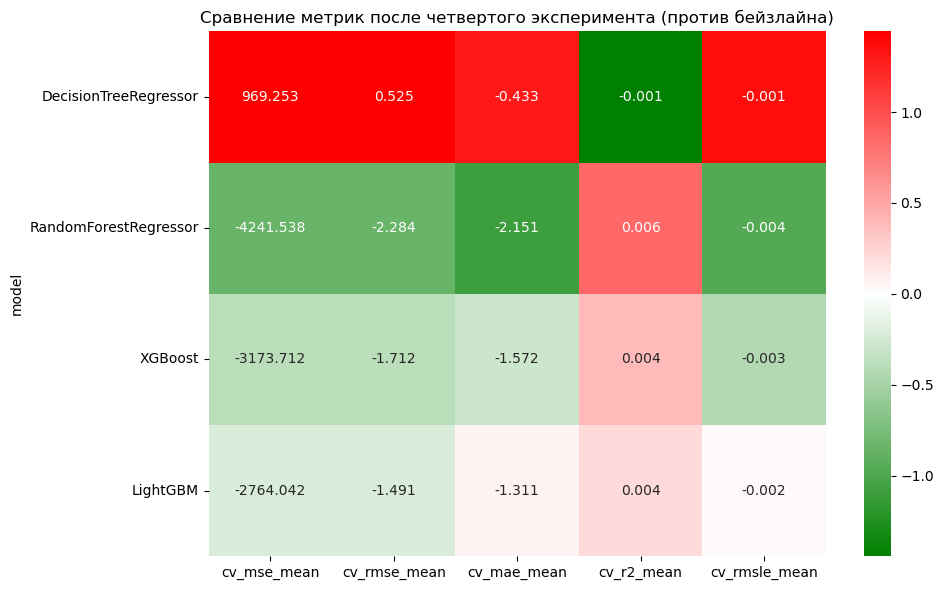

In [25]:
compare_after_add(exp4_metrics, baseline_metrics, 'Сравнение метрик после четвертого эксперимента (против бейзлайна)')

По сравнению со временем и качеством, на данный момент выигрывает модель XGBoost. Будем пробовать подобрать к нему гиперпараметры и улучшить метрики